In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import torch
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models
from goat_classifier import *

/opt/anaconda3/envs/AgrimoistNet/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/AgrimoistNet/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/envs/AgrimoistNet/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <CDAC6E34-8608-3E70-8B2F-32BCD38E90FB> /opt/anaconda3/envs/AgrimoistNet/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Parameter Setup

In [3]:
DATA_ROOT = '../../processed_dataset_highres' # 
IMAGE_SIZE = 128 
BATCH_SIZE = 32
NUM_EPOCHS = 200
LEARNING_RATE = 0.01
SAVE_PATH = 'goat_recognition_model.pth'

# Check Device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Visualizing 10 classes of cropped faces

Found 10 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


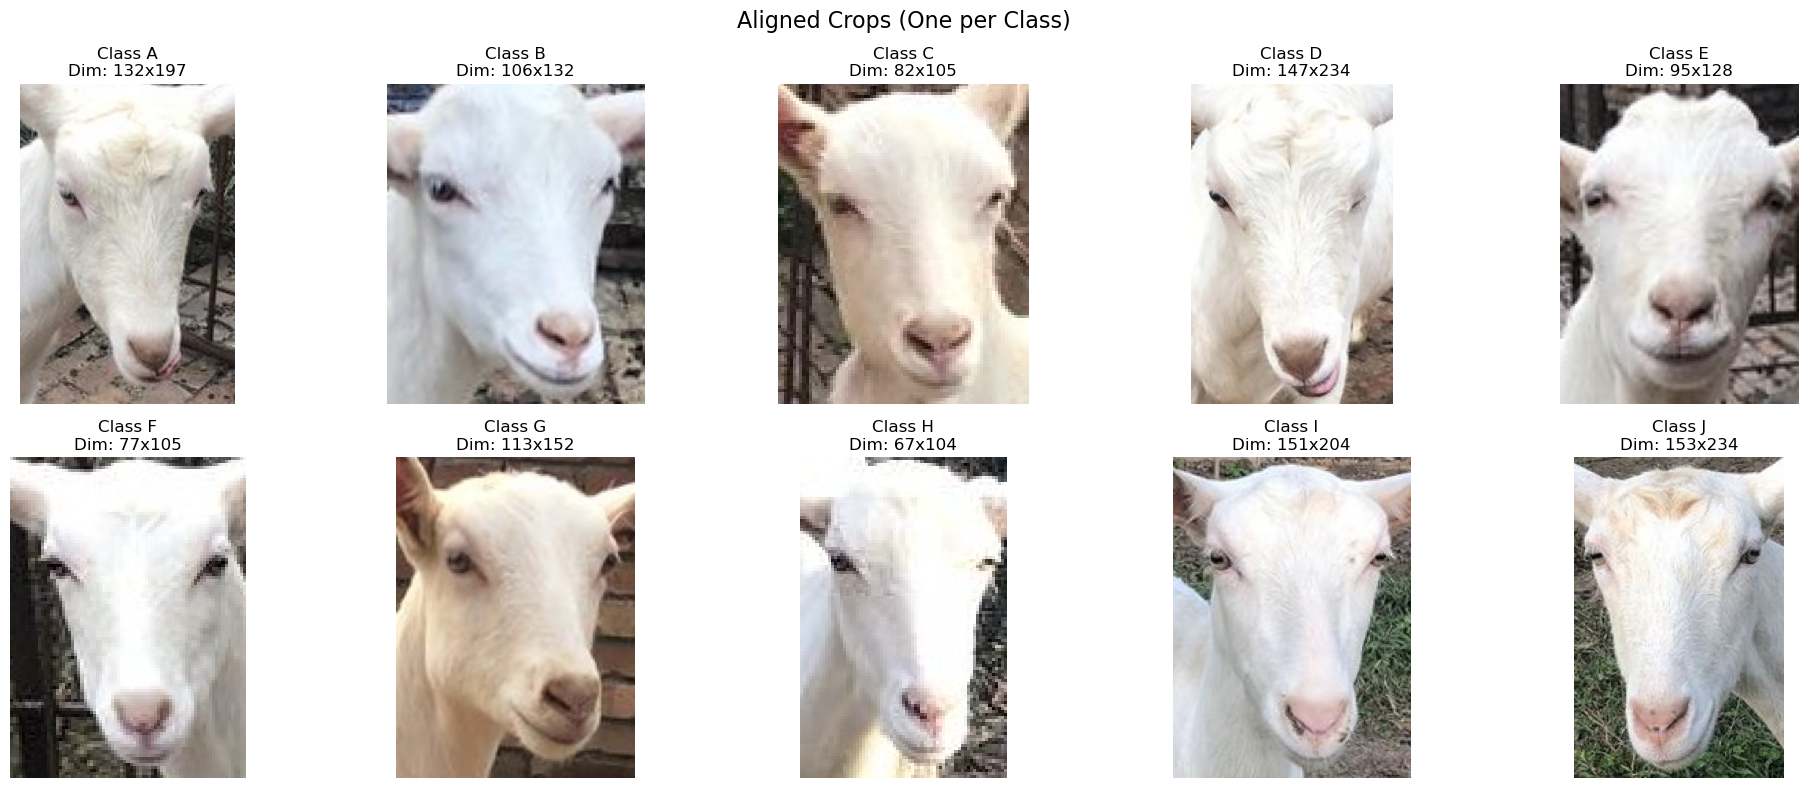

In [4]:
dataset_path = DATA_ROOT
if os.path.exists(dataset_path):
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print(f"Found {len(classes)} classes: {classes}")

    fig, axes = plt.subplots(2, 5, figsize=(20, 8)) # 2 rows, 5 columns grid
    fig.suptitle("Aligned Crops (One per Class)", fontsize=16)
    axes = axes.flatten()

    for i, class_name in enumerate(classes):
        if i >= 10: break # Only show first 10 classes
        
        class_dir = os.path.join(dataset_path, class_name)
        
        # Find first image (jpg or jpeg)
        image_files = glob.glob(os.path.join(class_dir, "*.[jJ][pP]*[gG]"))
        
        if image_files:
            # Load and Convert Color (OpenCV is BGR, Matplotlib is RGB)
            img = cv2.imread(image_files[0])
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Display
            axes[i].imshow(img_rgb)
            # Show dimensions 
            axes[i].set_title(f"Class {class_name}\nDim: {img.shape[1]}x{img.shape[0]}")
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "No Images", ha='center')

    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Directory '{dataset_path}' not found. Did you run the batch script?")

## Data preprocessing 

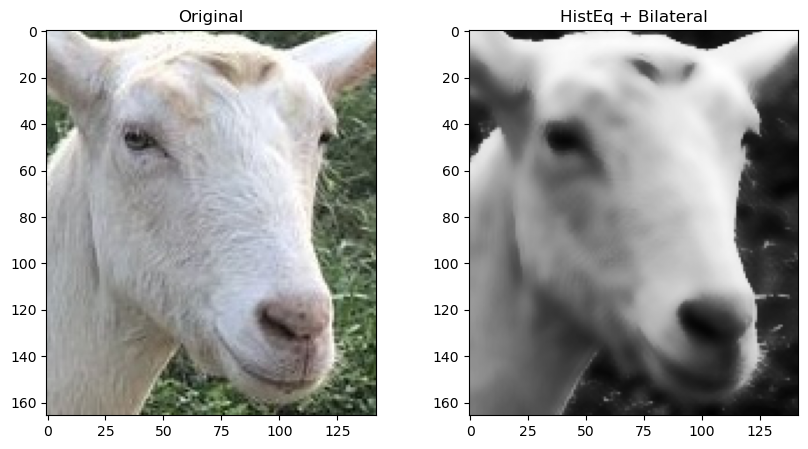

In [5]:
img = Image.open(image_files[5])
preprocessor = PaperPreprocessing()
# 3. Apply the processing
processed_img = preprocessor(img)

# 4. Compare Original vs Processed
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(processed_img, cmap='gray')
axes[1].set_title("HistEq + Bilateral")
    
plt.show()

## Defining transforms

In [6]:
# Training Transform: Includes Augmentation to fix overfitting
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
    PaperPreprocessing(),                        # Converts to Grayscale + Equalizes
    transforms.RandomHorizontalFlip(p=0.5),
   transforms.RandomRotation(10),
   transforms.ColorJitter(brightness=0.2, contrast=0.2), 

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

# Validation Transform: No random augmentation
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    PaperPreprocessing(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
# Load raw data
full_dataset = ImageFolder(root=DATA_ROOT) 

# Split indices
train_size = int(0.85 * len(full_dataset)) # 80% Training [cite: 179]
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size], 
                                        generator=torch.Generator().manual_seed(42))

In [8]:
train_data = TransformedSubset(train_subset, train_transform)
val_data = TransformedSubset(val_subset, val_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
NUM_CLASSES = len(full_dataset.classes)
print(f"Classes: {NUM_CLASSES} | Train Images: {len(train_data)} | Val Images: {len(val_data)}")

Classes: 10 | Train Images: 555 | Val Images: 98


## Model Training - Custom Model (Billah et al ​(2022))

In [10]:
model = GoatNet(NUM_CLASSES).to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss() # 

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

In [11]:
print("\nStarting Training...")
    
for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = correct_val / total_val
    
    # Store History
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}: Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}")


Starting Training...


Epoch 1: Train Acc: 0.1640 | Val Acc: 0.1837 | Val Loss: 2.2722


Epoch 2: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.2419


Epoch 3: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.2280


Epoch 4: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.2153


Epoch 5: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.2080


Epoch 6: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.2034


Epoch 7: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1986


Epoch 8: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1984


Epoch 9: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1974


Epoch 10: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1968


Epoch 11: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1962


Epoch 12: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1937


Epoch 13: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1916


Epoch 14: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1949


Epoch 15: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1967


Epoch 16: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1999


Epoch 17: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1922


Epoch 18: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1946


Epoch 19: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1991


Epoch 20: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1997


Epoch 21: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1959


Epoch 22: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1938


Epoch 23: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1997


Epoch 24: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1954


Epoch 25: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1950


Epoch 26: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1907


Epoch 27: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1986


Epoch 28: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1962


Epoch 29: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1917


Epoch 30: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1893


Epoch 31: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1896


Epoch 32: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1899


Epoch 33: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1824


Epoch 34: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1811


Epoch 35: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1851


Epoch 36: Train Acc: 0.1748 | Val Acc: 0.1837 | Val Loss: 2.1734


Epoch 37: Train Acc: 0.1910 | Val Acc: 0.1837 | Val Loss: 2.1278


Epoch 38: Train Acc: 0.2144 | Val Acc: 0.1735 | Val Loss: 2.1665


Epoch 39: Train Acc: 0.2324 | Val Acc: 0.2245 | Val Loss: 2.1899


Epoch 40: Train Acc: 0.2324 | Val Acc: 0.2755 | Val Loss: 2.2388


Epoch 41: Train Acc: 0.2450 | Val Acc: 0.1939 | Val Loss: 2.1142


Epoch 42: Train Acc: 0.2721 | Val Acc: 0.2245 | Val Loss: 2.1587


Epoch 43: Train Acc: 0.2595 | Val Acc: 0.2755 | Val Loss: 2.0646


Epoch 44: Train Acc: 0.2775 | Val Acc: 0.2347 | Val Loss: 1.9683


Epoch 45: Train Acc: 0.2901 | Val Acc: 0.2755 | Val Loss: 1.8566


Epoch 46: Train Acc: 0.3225 | Val Acc: 0.3980 | Val Loss: 1.7834


Epoch 47: Train Acc: 0.3207 | Val Acc: 0.3776 | Val Loss: 1.8557


Epoch 48: Train Acc: 0.3009 | Val Acc: 0.3571 | Val Loss: 1.8445


Epoch 49: Train Acc: 0.3441 | Val Acc: 0.4286 | Val Loss: 1.6510


Epoch 50: Train Acc: 0.3189 | Val Acc: 0.3980 | Val Loss: 1.7172


Epoch 51: Train Acc: 0.3477 | Val Acc: 0.4184 | Val Loss: 1.5509


Epoch 52: Train Acc: 0.3315 | Val Acc: 0.3163 | Val Loss: 1.8086


Epoch 53: Train Acc: 0.3766 | Val Acc: 0.4796 | Val Loss: 1.6398


Epoch 54: Train Acc: 0.3910 | Val Acc: 0.4592 | Val Loss: 1.5862


Epoch 55: Train Acc: 0.3892 | Val Acc: 0.4694 | Val Loss: 1.4505


Epoch 56: Train Acc: 0.4054 | Val Acc: 0.4898 | Val Loss: 1.4484


Epoch 57: Train Acc: 0.4018 | Val Acc: 0.5306 | Val Loss: 1.3583


Epoch 58: Train Acc: 0.4739 | Val Acc: 0.4694 | Val Loss: 1.3171


Epoch 59: Train Acc: 0.4090 | Val Acc: 0.3878 | Val Loss: 1.6075


Epoch 60: Train Acc: 0.4739 | Val Acc: 0.4898 | Val Loss: 1.4119


Epoch 61: Train Acc: 0.4541 | Val Acc: 0.5204 | Val Loss: 1.3499


Epoch 62: Train Acc: 0.5171 | Val Acc: 0.4694 | Val Loss: 1.4735


Epoch 63: Train Acc: 0.4865 | Val Acc: 0.4694 | Val Loss: 1.1363


Epoch 64: Train Acc: 0.4919 | Val Acc: 0.4796 | Val Loss: 1.4766


Epoch 65: Train Acc: 0.5315 | Val Acc: 0.5306 | Val Loss: 1.4010


Epoch 66: Train Acc: 0.5784 | Val Acc: 0.6122 | Val Loss: 1.1005


Epoch 67: Train Acc: 0.5712 | Val Acc: 0.6020 | Val Loss: 0.9610


Epoch 68: Train Acc: 0.6198 | Val Acc: 0.5306 | Val Loss: 1.4849


Epoch 69: Train Acc: 0.5586 | Val Acc: 0.6020 | Val Loss: 1.5274


Epoch 70: Train Acc: 0.5910 | Val Acc: 0.6122 | Val Loss: 1.0160


Epoch 71: Train Acc: 0.6234 | Val Acc: 0.5816 | Val Loss: 1.0842


Epoch 72: Train Acc: 0.6414 | Val Acc: 0.6735 | Val Loss: 0.8615


Epoch 73: Train Acc: 0.6667 | Val Acc: 0.6224 | Val Loss: 0.8325


Epoch 74: Train Acc: 0.6703 | Val Acc: 0.6020 | Val Loss: 1.1546


Epoch 75: Train Acc: 0.6360 | Val Acc: 0.6735 | Val Loss: 0.7627


Epoch 76: Train Acc: 0.6739 | Val Acc: 0.6837 | Val Loss: 0.8593


Epoch 77: Train Acc: 0.7225 | Val Acc: 0.7245 | Val Loss: 0.6381


Epoch 78: Train Acc: 0.6847 | Val Acc: 0.6633 | Val Loss: 1.0404


Epoch 79: Train Acc: 0.6937 | Val Acc: 0.6837 | Val Loss: 0.8790


Epoch 80: Train Acc: 0.7207 | Val Acc: 0.7143 | Val Loss: 0.8553


Epoch 81: Train Acc: 0.7261 | Val Acc: 0.7551 | Val Loss: 0.7974


Epoch 82: Train Acc: 0.6883 | Val Acc: 0.6837 | Val Loss: 0.7276


Epoch 83: Train Acc: 0.7189 | Val Acc: 0.7551 | Val Loss: 0.5929


Epoch 84: Train Acc: 0.7640 | Val Acc: 0.7755 | Val Loss: 0.6649


Epoch 85: Train Acc: 0.7784 | Val Acc: 0.7143 | Val Loss: 0.6769


Epoch 86: Train Acc: 0.7838 | Val Acc: 0.8163 | Val Loss: 0.4921


Epoch 87: Train Acc: 0.8054 | Val Acc: 0.7551 | Val Loss: 0.6455


Epoch 88: Train Acc: 0.8126 | Val Acc: 0.7347 | Val Loss: 0.6646


Epoch 89: Train Acc: 0.8342 | Val Acc: 0.7551 | Val Loss: 0.9956


Epoch 90: Train Acc: 0.8396 | Val Acc: 0.8367 | Val Loss: 0.5913


Epoch 91: Train Acc: 0.8595 | Val Acc: 0.8469 | Val Loss: 0.4573


Epoch 92: Train Acc: 0.8198 | Val Acc: 0.7959 | Val Loss: 0.6243


Epoch 93: Train Acc: 0.8396 | Val Acc: 0.8061 | Val Loss: 0.5564


Epoch 94: Train Acc: 0.8486 | Val Acc: 0.8061 | Val Loss: 0.6117


Epoch 95: Train Acc: 0.8270 | Val Acc: 0.7551 | Val Loss: 0.9208


Epoch 96: Train Acc: 0.8144 | Val Acc: 0.8367 | Val Loss: 0.4811


Epoch 97: Train Acc: 0.8577 | Val Acc: 0.8367 | Val Loss: 0.5762


Epoch 98: Train Acc: 0.8270 | Val Acc: 0.8878 | Val Loss: 0.4030


Epoch 99: Train Acc: 0.8703 | Val Acc: 0.8673 | Val Loss: 0.5583


Epoch 100: Train Acc: 0.8757 | Val Acc: 0.8469 | Val Loss: 0.6449


Epoch 101: Train Acc: 0.8757 | Val Acc: 0.8571 | Val Loss: 0.5076


Epoch 102: Train Acc: 0.9171 | Val Acc: 0.8163 | Val Loss: 0.6061


Epoch 103: Train Acc: 0.8793 | Val Acc: 0.7653 | Val Loss: 0.7173


Epoch 104: Train Acc: 0.8793 | Val Acc: 0.8061 | Val Loss: 1.2606


Epoch 105: Train Acc: 0.8937 | Val Acc: 0.8776 | Val Loss: 0.4785


Epoch 106: Train Acc: 0.8937 | Val Acc: 0.8673 | Val Loss: 0.4292


Epoch 107: Train Acc: 0.9135 | Val Acc: 0.8367 | Val Loss: 0.8747


Epoch 108: Train Acc: 0.8901 | Val Acc: 0.7959 | Val Loss: 0.7771


Epoch 109: Train Acc: 0.8937 | Val Acc: 0.8265 | Val Loss: 0.5705


Epoch 110: Train Acc: 0.8721 | Val Acc: 0.7653 | Val Loss: 0.6260


Epoch 111: Train Acc: 0.8901 | Val Acc: 0.7755 | Val Loss: 0.6132


Epoch 112: Train Acc: 0.8847 | Val Acc: 0.7959 | Val Loss: 0.5475


Epoch 113: Train Acc: 0.8937 | Val Acc: 0.7551 | Val Loss: 0.7160


Epoch 114: Train Acc: 0.9153 | Val Acc: 0.8163 | Val Loss: 0.5632


Epoch 115: Train Acc: 0.8775 | Val Acc: 0.8061 | Val Loss: 0.5996


Epoch 116: Train Acc: 0.9117 | Val Acc: 0.7755 | Val Loss: 0.7756


Epoch 117: Train Acc: 0.8432 | Val Acc: 0.7551 | Val Loss: 0.5817


Epoch 118: Train Acc: 0.8865 | Val Acc: 0.8163 | Val Loss: 0.6049


Epoch 119: Train Acc: 0.9153 | Val Acc: 0.8265 | Val Loss: 0.5683


Epoch 120: Train Acc: 0.9405 | Val Acc: 0.7959 | Val Loss: 0.9101


Epoch 121: Train Acc: 0.8991 | Val Acc: 0.8061 | Val Loss: 0.4655


Epoch 122: Train Acc: 0.9333 | Val Acc: 0.8367 | Val Loss: 0.4768


Epoch 123: Train Acc: 0.9405 | Val Acc: 0.8469 | Val Loss: 0.5942


Epoch 124: Train Acc: 0.9315 | Val Acc: 0.8673 | Val Loss: 0.5302


Epoch 125: Train Acc: 0.9333 | Val Acc: 0.8061 | Val Loss: 0.6516


Epoch 126: Train Acc: 0.9297 | Val Acc: 0.8469 | Val Loss: 0.4790


Epoch 127: Train Acc: 0.9459 | Val Acc: 0.8469 | Val Loss: 0.5550


Epoch 128: Train Acc: 0.9369 | Val Acc: 0.8571 | Val Loss: 0.5568


Epoch 129: Train Acc: 0.9622 | Val Acc: 0.8367 | Val Loss: 0.6270


Epoch 130: Train Acc: 0.9351 | Val Acc: 0.8061 | Val Loss: 0.7058


Epoch 131: Train Acc: 0.9153 | Val Acc: 0.8571 | Val Loss: 0.4585


Epoch 132: Train Acc: 0.9550 | Val Acc: 0.8673 | Val Loss: 0.4958


Epoch 133: Train Acc: 0.9423 | Val Acc: 0.8571 | Val Loss: 0.5612


Epoch 134: Train Acc: 0.9694 | Val Acc: 0.8163 | Val Loss: 0.6829


Epoch 135: Train Acc: 0.9495 | Val Acc: 0.8367 | Val Loss: 0.5402


Epoch 136: Train Acc: 0.9495 | Val Acc: 0.8571 | Val Loss: 0.5116


Epoch 137: Train Acc: 0.9550 | Val Acc: 0.8776 | Val Loss: 0.6386


Epoch 138: Train Acc: 0.9369 | Val Acc: 0.7857 | Val Loss: 0.6595


Epoch 139: Train Acc: 0.9514 | Val Acc: 0.8571 | Val Loss: 0.4934


Epoch 140: Train Acc: 0.9459 | Val Acc: 0.8673 | Val Loss: 0.4759


Epoch 141: Train Acc: 0.9604 | Val Acc: 0.8673 | Val Loss: 0.4789


Epoch 142: Train Acc: 0.9477 | Val Acc: 0.8776 | Val Loss: 0.4915


Epoch 143: Train Acc: 0.9604 | Val Acc: 0.8571 | Val Loss: 0.4607


Epoch 144: Train Acc: 0.9748 | Val Acc: 0.8776 | Val Loss: 0.4416


Epoch 145: Train Acc: 0.9784 | Val Acc: 0.8673 | Val Loss: 0.5673


Epoch 146: Train Acc: 0.9802 | Val Acc: 0.8469 | Val Loss: 0.5819


Epoch 147: Train Acc: 0.9730 | Val Acc: 0.8673 | Val Loss: 0.5049


Epoch 148: Train Acc: 0.9730 | Val Acc: 0.8367 | Val Loss: 0.6375


Epoch 149: Train Acc: 0.9694 | Val Acc: 0.8469 | Val Loss: 0.6389


Epoch 150: Train Acc: 0.9694 | Val Acc: 0.8265 | Val Loss: 0.6463


Epoch 151: Train Acc: 0.9550 | Val Acc: 0.8061 | Val Loss: 1.7881


Epoch 152: Train Acc: 0.9532 | Val Acc: 0.8469 | Val Loss: 0.5960


Epoch 153: Train Acc: 0.9658 | Val Acc: 0.8776 | Val Loss: 0.5217


Epoch 154: Train Acc: 0.9766 | Val Acc: 0.8469 | Val Loss: 0.7360


Epoch 155: Train Acc: 0.9658 | Val Acc: 0.8163 | Val Loss: 0.6876


Epoch 156: Train Acc: 0.9748 | Val Acc: 0.8571 | Val Loss: 0.7064


Epoch 157: Train Acc: 0.9676 | Val Acc: 0.8776 | Val Loss: 0.4886


Epoch 158: Train Acc: 0.9640 | Val Acc: 0.8878 | Val Loss: 0.4120


Epoch 159: Train Acc: 0.9694 | Val Acc: 0.8571 | Val Loss: 0.5420


Epoch 160: Train Acc: 0.9784 | Val Acc: 0.8878 | Val Loss: 0.5850


Epoch 161: Train Acc: 0.9712 | Val Acc: 0.8878 | Val Loss: 0.4780


Epoch 162: Train Acc: 0.9784 | Val Acc: 0.8469 | Val Loss: 0.6086


Epoch 163: Train Acc: 0.9802 | Val Acc: 0.8878 | Val Loss: 0.4538


Epoch 164: Train Acc: 0.9838 | Val Acc: 0.8878 | Val Loss: 0.6076


Epoch 165: Train Acc: 0.9874 | Val Acc: 0.8776 | Val Loss: 0.6787


Epoch 166: Train Acc: 0.9423 | Val Acc: 0.8571 | Val Loss: 0.7251


Epoch 167: Train Acc: 0.9387 | Val Acc: 0.8878 | Val Loss: 0.5659


Epoch 168: Train Acc: 0.9712 | Val Acc: 0.8980 | Val Loss: 0.6044


Epoch 169: Train Acc: 0.9568 | Val Acc: 0.8673 | Val Loss: 0.9478


Epoch 170: Train Acc: 0.9568 | Val Acc: 0.8469 | Val Loss: 1.3364


Epoch 171: Train Acc: 0.9586 | Val Acc: 0.9082 | Val Loss: 0.4210


Epoch 172: Train Acc: 0.9784 | Val Acc: 0.8878 | Val Loss: 0.5261


Epoch 173: Train Acc: 0.9766 | Val Acc: 0.8776 | Val Loss: 1.3161


Epoch 174: Train Acc: 0.9820 | Val Acc: 0.8673 | Val Loss: 0.4826


Epoch 175: Train Acc: 0.9892 | Val Acc: 0.8878 | Val Loss: 0.6543


Epoch 176: Train Acc: 0.9784 | Val Acc: 0.8673 | Val Loss: 0.5824


Epoch 177: Train Acc: 0.9820 | Val Acc: 0.8878 | Val Loss: 0.5010


Epoch 178: Train Acc: 0.9838 | Val Acc: 0.8776 | Val Loss: 0.5441


Epoch 179: Train Acc: 0.9802 | Val Acc: 0.8776 | Val Loss: 0.5427


Epoch 180: Train Acc: 0.9838 | Val Acc: 0.8980 | Val Loss: 0.5412


Epoch 181: Train Acc: 0.9784 | Val Acc: 0.9082 | Val Loss: 0.5498


Epoch 182: Train Acc: 0.9766 | Val Acc: 0.8878 | Val Loss: 0.4797


Epoch 183: Train Acc: 0.9676 | Val Acc: 0.8776 | Val Loss: 0.6541


Epoch 184: Train Acc: 0.9712 | Val Acc: 0.8878 | Val Loss: 0.6078


Epoch 185: Train Acc: 0.9766 | Val Acc: 0.8673 | Val Loss: 0.6403


Epoch 186: Train Acc: 0.9712 | Val Acc: 0.8980 | Val Loss: 0.5038


Epoch 187: Train Acc: 0.9658 | Val Acc: 0.8776 | Val Loss: 0.4668


Epoch 188: Train Acc: 0.9694 | Val Acc: 0.8673 | Val Loss: 0.4429


Epoch 189: Train Acc: 0.9856 | Val Acc: 0.8980 | Val Loss: 0.4525


Epoch 190: Train Acc: 0.9820 | Val Acc: 0.8980 | Val Loss: 0.4263


Epoch 191: Train Acc: 0.9856 | Val Acc: 0.9082 | Val Loss: 0.4604


Epoch 192: Train Acc: 0.9892 | Val Acc: 0.8673 | Val Loss: 0.3514


Epoch 193: Train Acc: 0.9622 | Val Acc: 0.8673 | Val Loss: 0.5166


Epoch 194: Train Acc: 0.9748 | Val Acc: 0.8571 | Val Loss: 0.5744


Epoch 195: Train Acc: 0.9892 | Val Acc: 0.8571 | Val Loss: 0.7971


Epoch 196: Train Acc: 0.9910 | Val Acc: 0.8673 | Val Loss: 0.6533


Epoch 197: Train Acc: 0.9820 | Val Acc: 0.8776 | Val Loss: 0.4420


Epoch 198: Train Acc: 0.9838 | Val Acc: 0.8878 | Val Loss: 0.4129


Epoch 199: Train Acc: 0.9748 | Val Acc: 0.8878 | Val Loss: 0.4035


Epoch 200: Train Acc: 0.9838 | Val Acc: 0.8980 | Val Loss: 0.3845


Training Complete. Results saved.


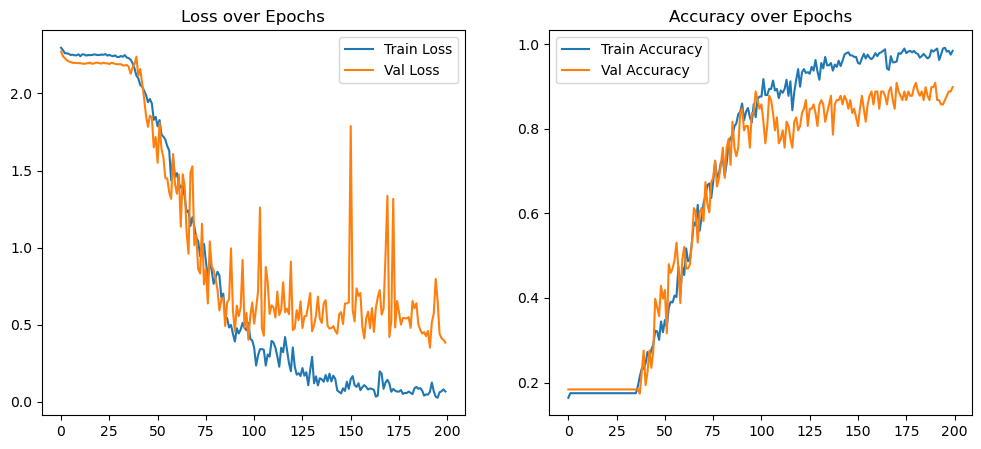

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.savefig('final_training_results.png')
print("Training Complete. Results saved.")

## Model Saving 

In [13]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': full_dataset.class_to_idx,
    'idx_to_class': {v: k for k, v in full_dataset.class_to_idx.items()},
    'image_size': IMAGE_SIZE,
    'num_classes': NUM_CLASSES
}, SAVE_PATH)

## Model Evaluation and Inference

In [14]:
model_path = SAVE_PATH
checkpoint = torch.load(model_path, map_location=device)
# Initialize model architecture
model = GoatNet(num_classes=checkpoint['num_classes']).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval() # Set to evaluation mode (turns off Dropout)
print("Model loaded successfully.")

Model loaded successfully.


In [15]:
# 4. Run Inference
y_true = []
y_pred = []

print("Running evaluation...")
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Store results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        
#  Generate Metrics
# Get class names in the correct order (0, 1, 2...)
class_names = full_dataset.classes 

# Print Report
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(y_true, y_pred, target_names=class_names))

Running evaluation...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A       0.90      0.90      0.90        10
           B       0.80      1.00      0.89         8
           C       0.86      1.00      0.92         6
           D       0.89      0.89      0.89         9
           E       0.89      0.94      0.92        18
           F       1.00      0.85      0.92        13
           G       0.92      1.00      0.96        12
           H       0.89      0.73      0.80        11
           I       1.00      0.67      0.80         3
           J       0.88      0.88      0.88         8

    accuracy                           0.90        98
   macro avg       0.90      0.88      0.89        98
weighted avg       0.90      0.90      0.90        98



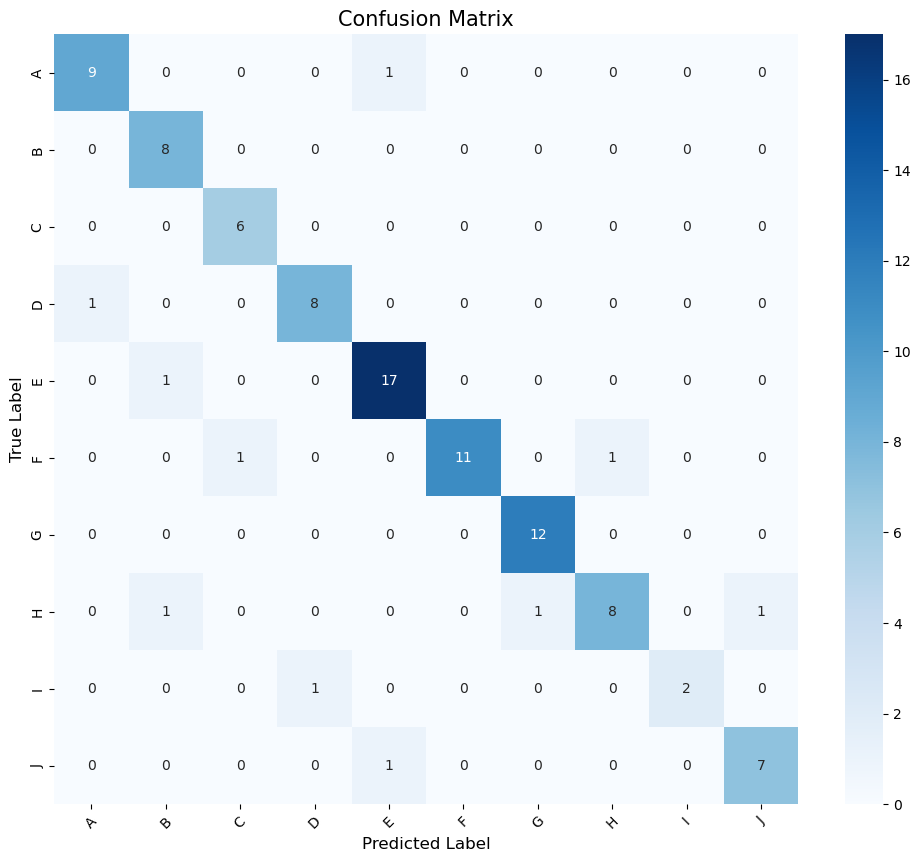

In [16]:
# 6. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.xticks(rotation=45)
plt.show()

# Pretrained Model

In [17]:
model = PretrainedGoatNet(NUM_CLASSES, pretrained=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)  
criterion = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

In [18]:
print("\nStarting Training...")
    
for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train
    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = correct_val / total_val
    
    # Store History
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}: Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f} | Val Loss: {epoch_val_loss:.4f}")


Starting Training...


Epoch 1: Train Acc: 0.1495 | Val Acc: 0.0918 | Val Loss: 2.4272


Epoch 2: Train Acc: 0.3135 | Val Acc: 0.2551 | Val Loss: 1.8072


Epoch 3: Train Acc: 0.4054 | Val Acc: 0.5000 | Val Loss: 1.4112


Epoch 4: Train Acc: 0.5207 | Val Acc: 0.5306 | Val Loss: 1.1706


Epoch 5: Train Acc: 0.6378 | Val Acc: 0.6837 | Val Loss: 0.8119


Epoch 6: Train Acc: 0.7279 | Val Acc: 0.7041 | Val Loss: 0.8134


Epoch 7: Train Acc: 0.7748 | Val Acc: 0.7857 | Val Loss: 0.6550


Epoch 8: Train Acc: 0.8324 | Val Acc: 0.7959 | Val Loss: 0.4703


Epoch 9: Train Acc: 0.8631 | Val Acc: 0.7959 | Val Loss: 0.4315


Epoch 10: Train Acc: 0.8739 | Val Acc: 0.8367 | Val Loss: 0.4212


Epoch 11: Train Acc: 0.8937 | Val Acc: 0.8367 | Val Loss: 0.4157


Epoch 12: Train Acc: 0.9207 | Val Acc: 0.8265 | Val Loss: 0.3951


Epoch 13: Train Acc: 0.9279 | Val Acc: 0.8469 | Val Loss: 0.3341


Epoch 14: Train Acc: 0.9514 | Val Acc: 0.8980 | Val Loss: 0.3195


Epoch 15: Train Acc: 0.9495 | Val Acc: 0.8673 | Val Loss: 0.3281


Epoch 16: Train Acc: 0.9712 | Val Acc: 0.9082 | Val Loss: 0.3052


Epoch 17: Train Acc: 0.9712 | Val Acc: 0.8980 | Val Loss: 0.3239


Epoch 18: Train Acc: 0.9694 | Val Acc: 0.8776 | Val Loss: 0.2940


Epoch 19: Train Acc: 0.9550 | Val Acc: 0.9184 | Val Loss: 0.2638


Epoch 20: Train Acc: 0.9622 | Val Acc: 0.8673 | Val Loss: 0.2803


Epoch 21: Train Acc: 0.9766 | Val Acc: 0.9184 | Val Loss: 0.2574


Epoch 22: Train Acc: 0.9748 | Val Acc: 0.9286 | Val Loss: 0.2088


Epoch 23: Train Acc: 0.9838 | Val Acc: 0.9388 | Val Loss: 0.2108


Epoch 24: Train Acc: 0.9802 | Val Acc: 0.8980 | Val Loss: 0.2682


Epoch 25: Train Acc: 0.9784 | Val Acc: 0.8980 | Val Loss: 0.2759


Epoch 26: Train Acc: 0.9856 | Val Acc: 0.8878 | Val Loss: 0.2552


Epoch 27: Train Acc: 0.9892 | Val Acc: 0.8980 | Val Loss: 0.2659


Epoch 28: Train Acc: 0.9802 | Val Acc: 0.8673 | Val Loss: 0.2827


Epoch 29: Train Acc: 0.9784 | Val Acc: 0.9388 | Val Loss: 0.1954


Epoch 30: Train Acc: 0.9910 | Val Acc: 0.9388 | Val Loss: 0.2020


Epoch 31: Train Acc: 0.9910 | Val Acc: 0.9286 | Val Loss: 0.2043


Epoch 32: Train Acc: 0.9838 | Val Acc: 0.8776 | Val Loss: 0.2992


Epoch 33: Train Acc: 0.9892 | Val Acc: 0.8980 | Val Loss: 0.2925


Epoch 34: Train Acc: 0.9946 | Val Acc: 0.9694 | Val Loss: 0.1897


Epoch 35: Train Acc: 0.9874 | Val Acc: 0.9286 | Val Loss: 0.2034


Epoch 36: Train Acc: 0.9874 | Val Acc: 0.9082 | Val Loss: 0.2714


Epoch 37: Train Acc: 0.9892 | Val Acc: 0.9184 | Val Loss: 0.2345


Epoch 38: Train Acc: 0.9802 | Val Acc: 0.9286 | Val Loss: 0.2224


Epoch 39: Train Acc: 0.9928 | Val Acc: 0.9592 | Val Loss: 0.2228


Epoch 40: Train Acc: 0.9874 | Val Acc: 0.9184 | Val Loss: 0.2280


Epoch 41: Train Acc: 0.9838 | Val Acc: 0.9082 | Val Loss: 0.2430


Epoch 42: Train Acc: 0.9856 | Val Acc: 0.9082 | Val Loss: 0.1939


Epoch 43: Train Acc: 0.9910 | Val Acc: 0.9490 | Val Loss: 0.1770


Epoch 44: Train Acc: 0.9928 | Val Acc: 0.9082 | Val Loss: 0.2044


Epoch 45: Train Acc: 0.9982 | Val Acc: 0.9184 | Val Loss: 0.2261


Epoch 46: Train Acc: 0.9964 | Val Acc: 0.8980 | Val Loss: 0.2283


Epoch 47: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2015


Epoch 48: Train Acc: 0.9964 | Val Acc: 0.9388 | Val Loss: 0.1934


Epoch 49: Train Acc: 0.9964 | Val Acc: 0.8980 | Val Loss: 0.2260


Epoch 50: Train Acc: 1.0000 | Val Acc: 0.9082 | Val Loss: 0.2253


Epoch 51: Train Acc: 0.9964 | Val Acc: 0.9286 | Val Loss: 0.2063


Epoch 52: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2088


Epoch 53: Train Acc: 0.9946 | Val Acc: 0.9388 | Val Loss: 0.2007


Epoch 54: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2158


Epoch 55: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.1976


Epoch 56: Train Acc: 0.9982 | Val Acc: 0.9082 | Val Loss: 0.2630


Epoch 57: Train Acc: 0.9946 | Val Acc: 0.9184 | Val Loss: 0.2645


Epoch 58: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2258


Epoch 59: Train Acc: 0.9982 | Val Acc: 0.9082 | Val Loss: 0.2565


Epoch 60: Train Acc: 0.9982 | Val Acc: 0.9184 | Val Loss: 0.2319


Epoch 61: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2369


Epoch 62: Train Acc: 1.0000 | Val Acc: 0.9082 | Val Loss: 0.2265


Epoch 63: Train Acc: 0.9946 | Val Acc: 0.9490 | Val Loss: 0.1991


Epoch 64: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2012


Epoch 65: Train Acc: 0.9910 | Val Acc: 0.9286 | Val Loss: 0.2019


Epoch 66: Train Acc: 0.9964 | Val Acc: 0.9286 | Val Loss: 0.2060


Epoch 67: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.1943


Epoch 68: Train Acc: 0.9946 | Val Acc: 0.9490 | Val Loss: 0.2022


Epoch 69: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2023


Epoch 70: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.1999


Epoch 71: Train Acc: 0.9946 | Val Acc: 0.9184 | Val Loss: 0.2400


Epoch 72: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2123


Epoch 73: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2084


Epoch 74: Train Acc: 0.9964 | Val Acc: 0.9286 | Val Loss: 0.2800


Epoch 75: Train Acc: 0.9982 | Val Acc: 0.9184 | Val Loss: 0.3781


Epoch 76: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.3360


Epoch 77: Train Acc: 0.9982 | Val Acc: 0.8980 | Val Loss: 0.2872


Epoch 78: Train Acc: 1.0000 | Val Acc: 0.9082 | Val Loss: 0.2348


Epoch 79: Train Acc: 1.0000 | Val Acc: 0.9082 | Val Loss: 0.2435


Epoch 80: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2377


Epoch 81: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2276


Epoch 82: Train Acc: 0.9892 | Val Acc: 0.9184 | Val Loss: 0.2633


Epoch 83: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2519


Epoch 84: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2064


Epoch 85: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2209


Epoch 86: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.1930


Epoch 87: Train Acc: 0.9946 | Val Acc: 0.9286 | Val Loss: 0.2274


Epoch 88: Train Acc: 0.9964 | Val Acc: 0.8980 | Val Loss: 0.3559


Epoch 89: Train Acc: 0.9946 | Val Acc: 0.9388 | Val Loss: 0.1959


Epoch 90: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.1821


Epoch 91: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.1911


Epoch 92: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2175


Epoch 93: Train Acc: 0.9982 | Val Acc: 0.9184 | Val Loss: 0.2331


Epoch 94: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2246


Epoch 95: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2219


Epoch 96: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.1963


Epoch 97: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2010


Epoch 98: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.1852


Epoch 99: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.1852


Epoch 100: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.1890


Epoch 101: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.1871


Epoch 102: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2287


Epoch 103: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2276


Epoch 104: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2144


Epoch 105: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2498


Epoch 106: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2417


Epoch 107: Train Acc: 0.9982 | Val Acc: 0.9082 | Val Loss: 0.2678


Epoch 108: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2379


Epoch 109: Train Acc: 0.9964 | Val Acc: 0.9286 | Val Loss: 0.2668


Epoch 110: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2416


Epoch 111: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2244


Epoch 112: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2302


Epoch 113: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2357


Epoch 114: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2275


Epoch 115: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2240


Epoch 116: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2319


Epoch 117: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2251


Epoch 118: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2292


Epoch 119: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2274


Epoch 120: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2209


Epoch 121: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2129


Epoch 122: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2254


Epoch 123: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2280


Epoch 124: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2411


Epoch 125: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2336


Epoch 126: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2288


Epoch 127: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2331


Epoch 128: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2282


Epoch 129: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2261


Epoch 130: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2121


Epoch 131: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2553


Epoch 132: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2438


Epoch 133: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2322


Epoch 134: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2415


Epoch 135: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.2312


Epoch 136: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2217


Epoch 137: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.2029


Epoch 138: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2128


Epoch 139: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2433


Epoch 140: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2361


Epoch 141: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2298


Epoch 142: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2401


Epoch 143: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2394


Epoch 144: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2299


Epoch 145: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.2258


Epoch 146: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2132


Epoch 147: Train Acc: 0.9946 | Val Acc: 0.9592 | Val Loss: 0.2167


Epoch 148: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2225


Epoch 149: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2251


Epoch 150: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.1951


Epoch 151: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.1886


Epoch 152: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2031


Epoch 153: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.1917


Epoch 154: Train Acc: 0.9964 | Val Acc: 0.9490 | Val Loss: 0.1946


Epoch 155: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2028


Epoch 156: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2017


Epoch 157: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2120


Epoch 158: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2130


Epoch 159: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2153


Epoch 160: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2118


Epoch 161: Train Acc: 0.9982 | Val Acc: 0.9388 | Val Loss: 0.2271


Epoch 162: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2321


Epoch 163: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2169


Epoch 164: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2155


Epoch 165: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2187


Epoch 166: Train Acc: 0.9982 | Val Acc: 0.9592 | Val Loss: 0.2136


Epoch 167: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.1984


Epoch 168: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2020


Epoch 169: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2043


Epoch 170: Train Acc: 1.0000 | Val Acc: 0.9694 | Val Loss: 0.1893


Epoch 171: Train Acc: 1.0000 | Val Acc: 0.9694 | Val Loss: 0.1912


Epoch 172: Train Acc: 0.9982 | Val Acc: 0.9694 | Val Loss: 0.1814


Epoch 173: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2002


Epoch 174: Train Acc: 1.0000 | Val Acc: 0.9694 | Val Loss: 0.1814


Epoch 175: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2075


Epoch 176: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2172


Epoch 177: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2251


Epoch 178: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2472


Epoch 179: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2284


Epoch 180: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2174


Epoch 181: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2151


Epoch 182: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2105


Epoch 183: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.1894


Epoch 184: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.1961


Epoch 185: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2019


Epoch 186: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2237


Epoch 187: Train Acc: 1.0000 | Val Acc: 0.9388 | Val Loss: 0.2188


Epoch 188: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2196


Epoch 189: Train Acc: 0.9982 | Val Acc: 0.9490 | Val Loss: 0.2272


Epoch 190: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2324


Epoch 191: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2472


Epoch 192: Train Acc: 1.0000 | Val Acc: 0.9184 | Val Loss: 0.2672


Epoch 193: Train Acc: 1.0000 | Val Acc: 0.9286 | Val Loss: 0.2537


Epoch 194: Train Acc: 0.9982 | Val Acc: 0.9286 | Val Loss: 0.2474


Epoch 195: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2318


Epoch 196: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2249


Epoch 197: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2272


Epoch 198: Train Acc: 1.0000 | Val Acc: 0.9592 | Val Loss: 0.2223


Epoch 199: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2177


Epoch 200: Train Acc: 1.0000 | Val Acc: 0.9490 | Val Loss: 0.2229


Training Complete. Results saved.


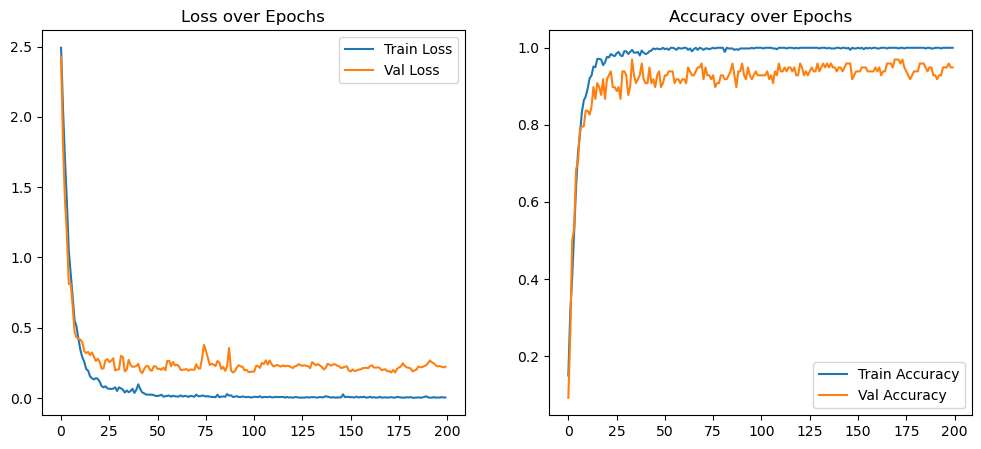

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.savefig('final_training_results.png')
print("Training Complete. Results saved.")

In [20]:
SAVE_PATH =  'goat_recognition_model_resnet18.pth'

In [21]:
torch.save({
    'model_state_dict': model.state_dict(),
    'class_to_idx': full_dataset.class_to_idx,
    'idx_to_class': {v: k for k, v in full_dataset.class_to_idx.items()},
    'image_size': IMAGE_SIZE,
    'num_classes': NUM_CLASSES
}, SAVE_PATH)

In [22]:
model_path = SAVE_PATH
checkpoint = torch.load(model_path, map_location=device)
model = PretrainedGoatNet(num_classes=checkpoint['num_classes']).to(device)

model.load_state_dict(checkpoint['model_state_dict'])

model.eval() 
print("✅ ResNet18 Model loaded successfully.")

class_mapping = checkpoint['idx_to_class']

✅ ResNet18 Model loaded successfully.


In [23]:
# 4. Run Inference
y_true = []
y_pred = []

print("Running evaluation...")
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # Store results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        
#  Generate Metrics
# Get class names in the correct order (0, 1, 2...)
class_names = full_dataset.classes 

# Print Report
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(y_true, y_pred, target_names=class_names))

Running evaluation...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A       0.82      0.90      0.86        10
           B       1.00      1.00      1.00         8
           C       1.00      1.00      1.00         6
           D       0.80      0.89      0.84         9
           E       1.00      1.00      1.00        18
           F       1.00      0.85      0.92        13
           G       1.00      1.00      1.00        12
           H       0.92      1.00      0.96        11
           I       1.00      1.00      1.00         3
           J       1.00      0.88      0.93         8

    accuracy                           0.95        98
   macro avg       0.95      0.95      0.95        98
weighted avg       0.95      0.95      0.95        98



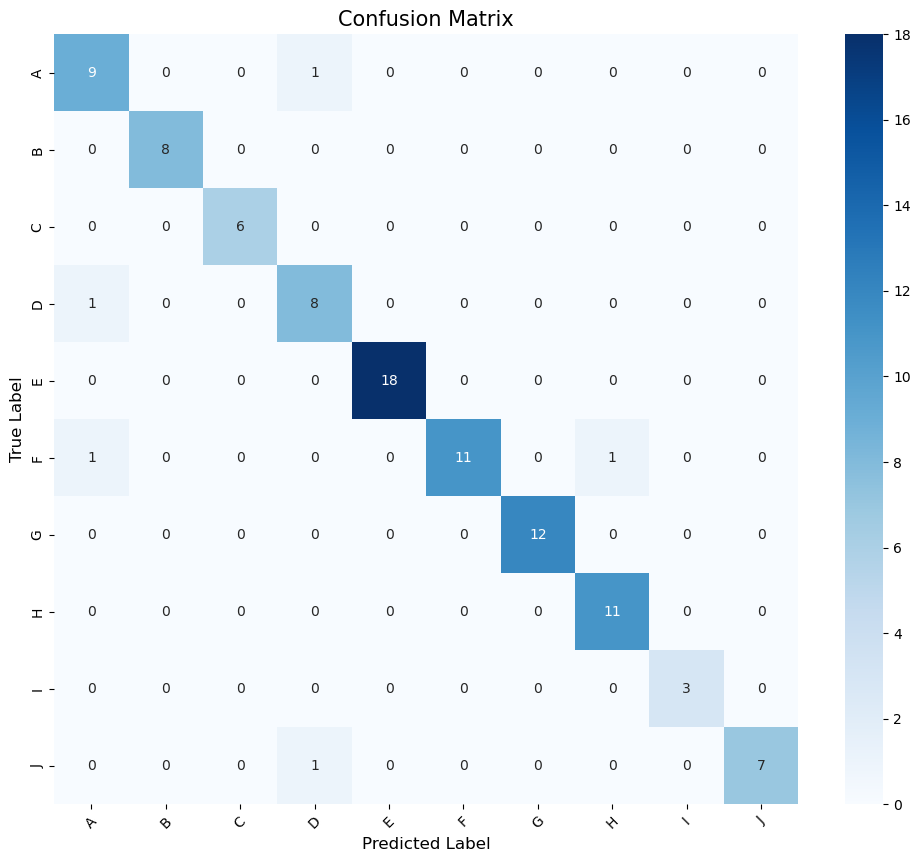

In [24]:
# 6. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.xticks(rotation=45)
plt.show()